In [1]:
#!pip install imbalanced-learn

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Function to load and preprocess data
def load_data_from_folder(folder_path, target_size=(256, 256)):
    images = []
    labels = []
    for subdir in os.listdir(folder_path):
        subdir_path = os.path.join(folder_path, subdir)
        if os.path.isdir(subdir_path):
            for filename in os.listdir(subdir_path):
                img_path = os.path.join(subdir_path, filename)
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image = load_img(img_path, target_size=target_size)
                    image = img_to_array(image) / 255.0  # Normalize to [0, 1]
                    images.append(image)
                    labels.append(subdir)  # Use subdirectory name as label
    return np.array(images), np.array(labels)

# Extract features using ResNet50
def extract_resnet50_features(images):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    features = base_model.predict(images)
    return features.reshape((features.shape[0], -1))  # Flatten features

# Handcrafted features (edge detection, texture, etc.)
def extract_handcrafted_features(images):
    feature_list = []
    for img in images:
        gray = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_BGR2GRAY)
        
        # Edge detection (Canny)
        edges = cv2.Canny(gray, 100, 200)
        
        # Texture detection (Laplacian)
        laplacian = cv2.Laplacian(gray, cv2.CV_64F).var()
        
        # Hough Line detection
        lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
        num_lines = len(lines) if lines is not None else 0
        
        # Combine handcrafted features
        handcrafted_features = [laplacian, num_lines]
        feature_list.append(handcrafted_features)
    return np.array(feature_list)

# Function to balance the dataset using SMOTE
def balance_dataset(X, y):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

# Load train data
train_data_path = r"C:\Users\ganga\Documents\IISc Coursework\ML4CPS\Project1\Project 1 Data\Project 1 Data\Train_Data"
train_images, train_labels = load_data_from_folder(train_data_path)

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Split into training and validation sets
train_images_split, val_images_split, train_labels_split, val_labels_split = train_test_split(
    train_images, train_labels_encoded, test_size=0.2, random_state=42)

# Extract ResNet50 features
resnet50_train_features = extract_resnet50_features(train_images_split)
resnet50_val_features = extract_resnet50_features(val_images_split)

# Extract handcrafted features (e.g., edges, lines)
handcrafted_train_features = extract_handcrafted_features(train_images_split)
handcrafted_val_features = extract_handcrafted_features(val_images_split)

# Combine features (ResNet50 + handcrafted)
X_train_combined = np.hstack([resnet50_train_features, handcrafted_train_features])
X_val_combined = np.hstack([resnet50_val_features, handcrafted_val_features])

# Balance the dataset using SMOTE
X_train_resampled, y_train_resampled = balance_dataset(X_train_combined, train_labels_split)

# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# Predict on validation data
val_predictions = rf.predict(X_val_combined)

# Evaluate the model
print(f'Validation Accuracy: {accuracy_score(val_labels_split, val_predictions)}')
print(classification_report(val_labels_split, val_predictions))


NameError: name 'preprocess_input' is not defined

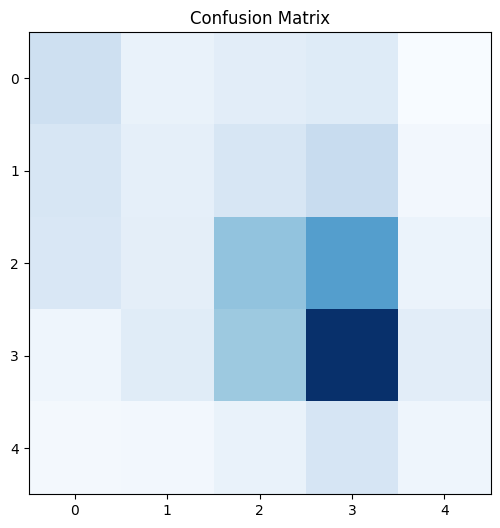

In [6]:

# Confusion matrix
conf_matrix = confusion_matrix(val_labels_split, val_predictions)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix')
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
# Preprocess test images
test_images = preprocess_input(test_images)

resnet50_test_features = extract_resnet50_features(test_images)
handcrafted_test_features = extract_handcrafted_features(test_images)

# Combine features for test set
X_test_combined = np.hstack([resnet50_test_features, handcrafted_test_features])

# Predict on test data
test_predictions = rf.predict(X_test_combined)

# Convert predictions to class labels
predicted_classes = label_encoder.inverse_transform(test_predictions)

# Visualize the results for a few test images
def plot_images_with_predictions(images, predictions, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f'Pred: {predictions[i]}')
        plt.axis('off')
    plt.show()

# Visualize predictions
plot_images_with_predictions(test_images, predicted_classes)

# Visualizing accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train')
    plt.plot(history['val_accuracy'], label='Val')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train')
    plt.plot(history['val_loss'], label='Val')
    plt.title('Loss')
    plt.legend()
    plt.show()

